In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from plotnine import *
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = pd.read_csv('proyectoData.csv') #Dataset utilizado

#Eliminamos variables con excesiva cantidad de datos nulos que no nos aportan al análisis, como las variables: G, condition_code,  extent,rot_per,GM,BV,UB,IR,spec_B,spec_T
data=data[["a","e","i","om","w","q","ad","per_y","data_arc","condition_code","n_obs_used","H","albedo","neo","pha","moid",'Danger']]
data.dropna(inplace=True)

In [3]:
data['target'] = data['Danger']

data["Danger"] = data["Danger"].replace({True: 1, False: 0})

#Transformación de las variables binarias a númericas mediante Si = 1, No = 0
data.groupby("pha").agg(frequency=("pha", "count")).head()
data["pha"] = data["pha"].replace({"Y": 1, "N": 0})
data.groupby("neo").agg(frequency=("neo", "count")).head()
data["neo"] = data["neo"].replace({"Y": 1, "N": 0})

In [5]:
from sklearn.model_selection import KFold
from itertools import compress
from sklearn import metrics as mt
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score
import random

In [6]:
kfolds = list(KFold(n_splits=10).split(data)) # Ejemplo para ver que entregar kfold
K_SPLITS=50

In [7]:
variables = ["a","e","i","om","w","q","ad","per_y","data_arc","n_obs_used","H","albedo","moid"] #variables a utilizar
CLASE_MODELO = BernoulliNB #vamos a trabajar las variables categoricas con una distribucion de bernoulli

In [8]:
#variaciones del modelo
categorical_variations = [
    ['neo'], 
    ['neo','pha'],
    ['pha']
]

numerical_variations = [
    [variables[0]],
    [variables[1],variables[2]],
    [variables[3],variables[4],variables[5]],
    [variables[6],variables[7],variables[8],variables[9]],
    [variables[10],variables[11],variables[12]]    
]

model_parameters_variations = [
    {'alpha':random.random(), 'binarize': random.random()},
    {'alpha':random.random(), 'binarize': random.random()}
]


In [9]:
variations = [] #permite realizar las variaciones
for categoricals_variation in categorical_variations:
    for numerical_variation in numerical_variations:
        for model_parameters_variation in model_parameters_variations:
            new_settings = {
                'categoricals': categoricals_variation
                ,'numericals': numerical_variation
                ,'model_parameters': model_parameters_variation
            }
            
            variations.append(new_settings)

In [10]:
final_results = [] # acumulador de resultados

for variation_settings in variations:
    for kfold_idx, (train_idx, test_idx) in enumerate(KFold(n_splits=10).split(data)):
        settings = variation_settings.copy() # para no editar el objeto inicial
        settings['all_vars'] = settings['categoricals'] + settings['numericals']

        # ojala generar un id
        settings['variation_id'] = str(settings['all_vars']) + '_' + str(settings['model_parameters'])
        settings['kfold_id'] = kfold_idx

        y_var = 'target'
        X_var = settings['all_vars']
        categoricals = settings['categoricals']
        numericals =  settings['numericals']

        # datos
        train = data.iloc[train_idx]
        test = data.iloc[test_idx]

        X_train = train[X_var]
        y_train = train[y_var]
        X_test = test[X_var]
        y_test = test[y_var]

       
        #####
        ## Entrenamiento
        #####
        modelo = CLASE_MODELO(**settings['model_parameters'])
        modelo.fit(X_train, y_train)
        

        # Predicciones
        y_train_prediction = modelo.predict(X_train)
        y_test_prediction = modelo.predict(X_test)

        y_train_prediction_proba = modelo.predict_proba(X_train)
        y_test_prediction_proba = modelo.predict_proba(X_test)
        

        # Testing
        train_f1score = f1_score(y_train, y_train_prediction)
        test_f1score = f1_score(y_test, y_test_prediction)

        # guardamos la data en el nuevo objeto settings
        # podemos guardar todas las cosas que sean relevantes
        settings['result_train_f1_score'] = train_f1score
        settings['result_test_f1_score'] = test_f1score

        final_results.append(settings)

<AxesSubplot:xlabel='result_test_f1_score', ylabel='variation_id'>

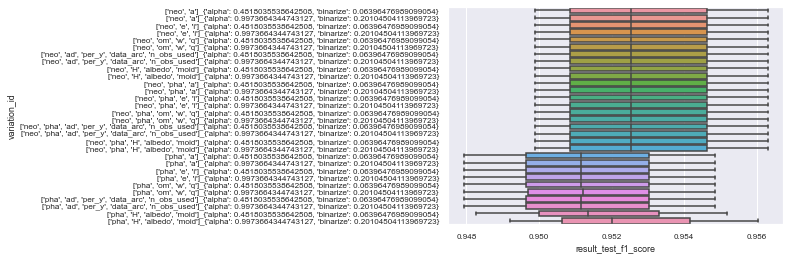

In [11]:
pd_final_results = pd.DataFrame(final_results)
sns.set(font_scale = 0.74)
sns.boxplot(data=pd_final_results, x='result_test_f1_score', y='variation_id')

In [12]:
pd_final_results.groupby(["variation_id"])['result_test_f1_score'].agg(["min","max","mean","std"])

,min,max,mean,std
variation_id,,,,
"['neo', 'H', 'albedo', 'moid']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",0.949901,0.956309,0.952785,0.002240
"['neo', 'H', 'albedo', 'moid']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",0.949901,0.956309,0.952785,0.002240
"['neo', 'a']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",0.949901,0.956309,0.952785,0.002240
"['neo', 'a']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",0.949901,0.956309,0.952785,0.002240
"['neo', 'ad', 'per_y', 'data_arc', 'n_obs_used']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",0.949901,0.956309,0.952785,0.002240
"['neo', 'ad', 'per_y', 'data_arc', 'n_obs_used']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",0.949901,0.956309,0.952785,0.002240
"['neo', 'e', 'i']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",0.949901,0.956309,0.952785,0.002240
"['neo', 'e', 'i']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",0.949901,0.956309,0.952785,0.002240
"['neo', 'om', 'w', 'q']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",0.949901,0.956309,0.952785,0.002240


<AxesSubplot:>

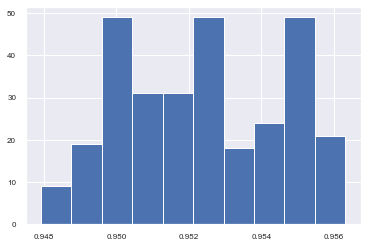

In [13]:
pd_final_results['result_test_f1_score'].hist()

In [14]:
pd.set_option('max_colwidth', None)
pd.DataFrame(final_results).sort_values(by=['result_test_f1_score','kfold_id'], ascending=False)


,categoricals,numericals,model_parameters,all_vars,variation_id,kfold_id,result_train_f1_score,result_test_f1_score
8,[neo],[a],"{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}","[neo, a]","['neo', 'a']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",8,0.952397,0.956309
18,[neo],[a],"{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}","[neo, a]","['neo', 'a']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",8,0.952397,0.956309
28,[neo],"[e, i]","{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}","[neo, e, i]","['neo', 'e', 'i']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",8,0.952397,0.956309
38,[neo],"[e, i]","{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}","[neo, e, i]","['neo', 'e', 'i']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",8,0.952397,0.956309
48,[neo],"[om, w, q]","{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}","[neo, om, w, q]","['neo', 'om', 'w', 'q']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",8,0.952397,0.956309
...,...,...,...,...,...,...,...,...
236,[pha],"[e, i]","{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}","[pha, e, i]","['pha', 'e', 'i']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",6,0.951740,0.947924
246,[pha],"[om, w, q]","{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}","[pha, om, w, q]","['pha', 'om', 'w', 'q']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",6,0.951740,0.947924
256,[pha],"[om, w, q]","{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}","[pha, om, w, q]","['pha', 'om', 'w', 'q']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",6,0.951763,0.947924
266,[pha],"[ad, per_y, data_arc, n_obs_used]","{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}","[pha, ad, per_y, data_arc, n_obs_used]","['pha', 'ad', 'per_y', 'data_arc', 'n_obs_used']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",6,0.951740,0.947924


In [15]:
 pd_final_results["variation_id"].unique() #resultados no repetidos

array(["['neo', 'a']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",
       "['neo', 'a']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",
       "['neo', 'e', 'i']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",
       "['neo', 'e', 'i']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",
       "['neo', 'om', 'w', 'q']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",
       "['neo', 'om', 'w', 'q']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",
       "['neo', 'ad', 'per_y', 'data_arc', 'n_obs_used']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",
       "['neo', 'ad', 'per_y', 'data_arc', 'n_obs_used']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",
       "['neo', 'H', 'albedo', 'moid']_{'alpha': 0.4818035538642508, 'binarize': 0.06396476989099054}",
       "['neo', 'H', 'albedo', 'moid']_{'alpha': 0.9973664344743127, 'binarize': 0.20104504113969723}",


In [16]:
#Modelo seleccionado

default_settings = {
    'categoricals': ['neo']
    ,'numericals': ['om','w','q']
    ,'model_parameters': {
        'alpha':0.6427173138788476, 
        'binarize': 0.07700533064122062
    }
}

CLASE_MODELO1= BernoulliNB

In [18]:
results = [] 

for kfold_idx, (train_idx, test_idx) in enumerate(KFold(n_splits=K_SPLITS).split(data)):
    settings = default_settings.copy() # para no editar el objeto inicial
    settings['all_vars'] = settings['categoricals'] + settings['numericals']
    
    # Generar id
    settings['variation_id'] = str(settings['all_vars']) + '_' + str(settings['model_parameters'])
    settings['kfold_id'] = kfold_idx

    y_var = 'Danger'
    X_var = settings['all_vars']
    categoricals = settings['categoricals']
    numericals =  settings['numericals']

    # Datos
    train = data.iloc[train_idx]
    test = data.iloc[test_idx]
    
    X_train = train[X_var]
    y_train = train[y_var]
    X_test = test[X_var]
    y_test = test[y_var]

    # Entrenamiento
    modelo = CLASE_MODELO(**settings['model_parameters'])
    modelo.fit(X_train, y_train)
    
    # Predicciones
    y_train_prediction = modelo.predict(X_train)
    y_test_prediction = modelo.predict(X_test)

    y_train_prediction_proba = modelo.predict_proba(X_train)
    y_test_prediction_proba = modelo.predict_proba(X_test)
    
    # Testeo
    train_f1score = f1_score(y_train, y_train_prediction)
    test_f1score = f1_score(y_test, y_test_prediction)

    # guardamos la data en el nuevo objeto settings
    # podemos guardar todas las cosas que sean relevantes
    settings['result_train_f1_score'] = train_f1score
    settings['result_test_f1_score'] = test_f1score
    
    results.append(settings)

<AxesSubplot:>

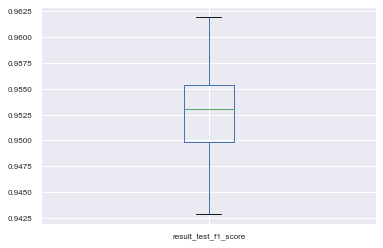

In [130]:
#Crear box plot f1 score
plt.figure(figsize=(x,y)) 

pd.DataFrame(results)['result_test_f1_score'].plot.box()


In [123]:
resultado=modelo.predict_proba(X_test)
print("Resultado de la predicción:\n",resultado)
resultado=modelo.predict(X_test)
print("Resultado de la predicción:\n",resultado)
print("Resultado original:\n",y_test)

Resultado de la predicción:
 [[0.08946123 0.91053877]
 [0.08946123 0.91053877]
 [0.08946123 0.91053877]
 ...
 [0.08946123 0.91053877]
 [0.08946123 0.91053877]
 [0.08946123 0.91053877]]
Resultado de la predicción:
 [1 1 1 ... 1 1 1]
Resultado original:
 97999    1
98000    1
98001    1
98002    1
98003    1
        ..
99995    1
99996    1
99997    1
99998    1
99999    1
Name: Danger, Length: 1976, dtype: int64


In [69]:
#Analizando los parámetros aprendidos
print("Probabilidades de las clases (a priori)\n",np.exp(modelo.class_log_prior_))

print("\nDistribuciones de cada variable dado :\n")
print("Condicionada en clase 0:",np.exp(modelo.feature_log_prob_[0]))
print("Condicionada en clase 1:",np.exp(modelo.feature_log_prob_[1]))

print("Condicionado en la clase 0:\n",(np.sum((X_train[y_train==0]>0))+modelo.alpha)/(np.sum(y_train==0)+2*modelo.alpha))
print("Condicionado en la clase 1:\n",(np.sum((X_train[y_train==1]>0))+modelo.alpha)/(np.sum(y_train==1)+2*modelo.alpha))


Probabilidades de las clases (a priori)
 [0.09405302 0.90594698]

Distribuciones de cada variable dado :

Condicionada en clase 0: [0.05441071 0.99981967 0.99960011 0.99992944]
Condicionada en clase 1: [9.98979075e-04 9.99741911e-01 9.99776106e-01 9.99992674e-01]
Condicionado en la clase 0:
 neo    0.054411
om     0.999929
w      0.999929
q      0.999929
dtype: float64
Condicionado en la clase 1:
 neo    0.000999
om     0.999993
w      0.999993
q      0.999993
dtype: float64


In [25]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_test_prediction))

Accuracy: 0.9101601627443489


<BarContainer object of 4 artists>

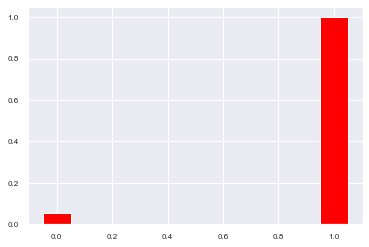

In [124]:
import matplotlib.pyplot as plt

ProbabilidadClase0 = (np.sum((X_train[y_train==0]>0))+modelo.alpha)/(np.sum(y_train==0)+2*modelo.alpha)
ProbabilidadClase1 = (np.sum((X_train[y_train==1]>0))+modelo.alpha)/(np.sum(y_train==1)+2*modelo.alpha)

plt.bar(ProbabilidadClase0, ProbabilidadClase1, color ='red', width = 0.1)